In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR


from tqdm import tqdm 
import numpy
import pandas as pd

### Model

In [2]:
class EnhancedFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(EnhancedFNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


In [3]:
df = pd.read_csv("/home/921642160/hackathon/D1.csv")
X_train = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

mean_X = torch.mean(X_train, dim=0)
std_X = torch.std(X_train, dim=0)
X_train_normalized = (X_train - mean_X) / (std_X + 1e-7)

mean_y = torch.mean(y_train)
std_y = torch.std(y_train)
y_train_normalized = (y_train - mean_y) / (std_y + 1e-7)

batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_normalized, y_train_normalized), batch_size=batch_size, shuffle=True)


In [4]:


# Hyperparameters
n_particles = 1  
input_dim = 8
hidden_dim = 32
hidden_dim2 = 16
output_dim = 1
learning_rate = 0.001
weight_decay = 0.01  
epochs = 1000

# Models 
ensemble = [EnhancedFNN(input_dim, hidden_dim, hidden_dim2, output_dim) for _ in range(n_particles)]
optimizers = [optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) for model in ensemble]
schedulers = [CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0) for optimizer in optimizers]



### Train 

In [5]:
epoch_losses = []
outer_tqdm = tqdm(range(epochs), desc='Epochs')
for epoch in outer_tqdm:
    epoch_loss_sum = 0.0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        batch_loss_sum = 0.0
        
        for j, model in enumerate(ensemble):
            optimizers[j].zero_grad()
            y_pred = model(X_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            loss.backward()
            optimizers[j].step()

            batch_loss_sum += loss.item()
        
        batch_loss_avg = batch_loss_sum / len(ensemble)
        epoch_loss_sum += batch_loss_avg

    # Update learning rate
    for scheduler in schedulers:
        scheduler.step()

    epoch_loss_avg = epoch_loss_sum / len(train_loader)
    epoch_losses.append(epoch_loss_avg)  # Append the average loss of this epoch to the list
    outer_tqdm.set_postfix({"Epoch Avg Loss": f"{epoch_loss_avg:.4f}"})

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]/home/921642160/anaconda3/envs/hack2/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epochs: 100%|██████████| 1000/1000 [01:04<00:00, 15.40it/s, Epoch Avg Loss=0.1810]


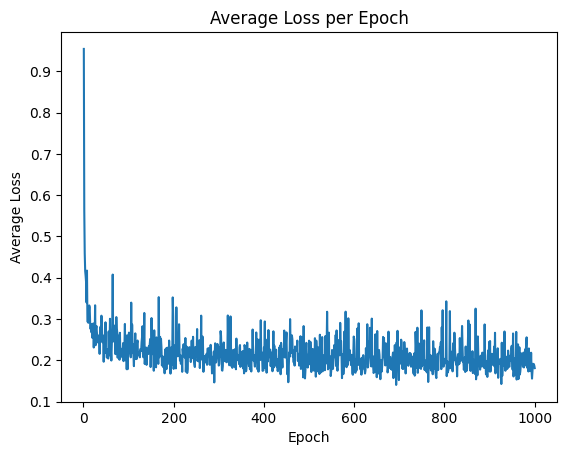

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.show()


### Test 

In [11]:
# Load test data
df_test = pd.read_csv("/home/921642160/hackathon/D2.csv")

X_test = torch.tensor(df_test.values, dtype=torch.float32)

X_test_normalized = (X_test - mean_X) / (std_X + 1e-7)

# Prepare DataLoader
test_loader = DataLoader(TensorDataset(X_test_normalized), batch_size=1)  # No y_test as you don't have labels

# Get number of samples and input dimensionality
n_samples = X_test.shape[0]
input_dim = X_test.shape[1]

print(n_samples)
print(input_dim)

311
8


In [8]:
# Initialize tensor to store ensemble predictions
ensemble_predictions = torch.zeros((n_samples, output_dim))

# Switch to evaluation mode for all models in the ensemble
for model in ensemble:
    model.eval()

# Testing loop with ensemble prediction
with torch.no_grad():
    for i, (X_batch,) in enumerate(test_loader):  # No y_batch as you don't have labels
        batch_predictions = torch.zeros((X_batch.size(0), output_dim))
        
        for j, model in enumerate(ensemble):
            y_pred = model(X_batch)
            batch_predictions += y_pred
        
        # Average the predictions for the ensemble
        batch_predictions /= len(ensemble)
        
        # Store ensemble predictions
        ensemble_predictions[i * X_batch.size(0): (i + 1) * X_batch.size(0), :] = batch_predictions



In [12]:
import numpy as np
# Unnormalize the ensemble predictions
ensemble_predictions_unnormalized = (ensemble_predictions * std_y) + mean_y

# Convert tensor to numpy array
ensemble_predictions_unnormalized_np = ensemble_predictions_unnormalized.numpy()

# Save as a CSV with 18 decimal places, without scientific notation
np.savetxt("ensemble_predictions_unnormalized.csv", ensemble_predictions_unnormalized_np, delimiter=",", fmt='%.2f')
